# 2


In [30]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from PIL import Image

# 2.1

In [31]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Load images from file

In [32]:
def loadImages(img_dir): # loads image from file and store the image with label
    images = []
    labels = []

    cat_dir = os.path.join(img_dir, "Cat")
    dog_dir = os.path.join(img_dir, "Dog")

    # Load all Cat images
    for filename in os.listdir(cat_dir):
        if not filename.lower().endswith('jpg'):
            continue
        img_path = os.path.join(cat_dir, filename)
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        images.append(image)
        labels.append(0)  # Label for cat is 0

    # Load all Dog images
    for filename in os.listdir(dog_dir):
        if not filename.lower().endswith('jpg'):
            continue
        img_path = os.path.join(dog_dir, filename)
        image = Image.open(img_path).convert("RGB")
        images.append(image)
        labels.append(1)  # Label for dog is 1

    return images, labels


images, labels = loadImages('pet_images')

# shuffle image and label
combined = list(zip(images, labels))
random.shuffle(combined)
images, labels = zip(*combined)

# Custom image dataset class 

In [33]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
            

### define transform (no augmentation)

In [34]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])  
])
# cat_dog_dataset = CustomImageDataset('pet_images', transform)

### split dataset into training, validation, and testing

In [35]:
# split dataset into 70% training 15% validation 15% testing

train_size = int(0.7 * len(labels))
val_size = int(0.15 * len(labels))
test_size = int(0.15 * len(labels))

# Split the data
train_image, train_label = images[:train_size], labels[:train_size]
val_image, val_label = images[train_size:train_size + val_size], labels[train_size:train_size + val_size]
test_image, test_label = images[train_size + val_size:], labels[train_size + val_size:]

# datasets
train_dataset = CustomImageDataset(train_image, train_label, transform=transform)
val_dataset = CustomImageDataset(val_image, val_label, transform=transform)
test_dataset = CustomImageDataset(test_image, test_label, transform=transform)


In [36]:
# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

tensor(0)


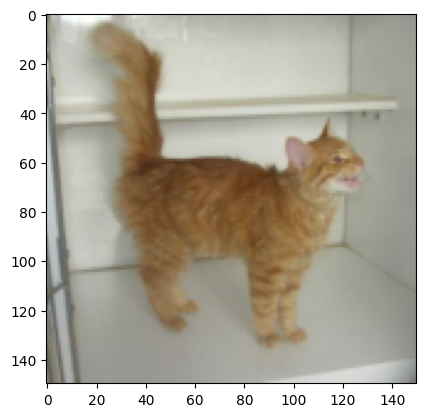

In [37]:
# test if dataloader is working as intended

images, labels = next(iter(train_dataloader))
print(labels[0])
plt.imshow(images[0].permute(1, 2, 0))

# 0 for cat, 1 for dog

# 2.2


# Custom CNN class

In [38]:
# defining out CNN

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # input is 150 x 150 x 3

        # Convolutional and normalizing layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # output: 150 x 150 x 32
        self.bn1 = nn.BatchNorm2d(32)
        # first pooling -> 75 x 75 x 32

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # output 75 x 75 x 64
        self.bn2 = nn.BatchNorm2d(64)
        # second pooling -> 37 x 37 x 64

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # output: 37 x 37 x 128
        self.bn3 = nn.BatchNorm2d(128)
        # third pooling -> 18 x 18 x 128 (input size for first fc layer)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) # output: 18 x 18 x 128
        self.bn4 = nn.BatchNorm2d(128)
        # fourth pooling -> 9 x 9 x 128 (input size for first fc layer)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dense layers
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        # self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

        # dropout
        self.dropout = nn.Dropout()

        # activation 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()
        

    def forward(self, x):
        # conv layers with norm and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # flatten
        x = self.flatten(x)

        # dense layers
        x = self.fc3(
                self.dropout(
                    self.relu(
                        self.fc1(x))))
        x = self.sigmoid(x)

        return x


### Define CNN Model, criterion, and optimizer

In [39]:
cnnModel = CNN().to(device)
print(cnnModel)
criterion = nn.BCELoss()
optimizer = optim.Adam(cnnModel.parameters(), lr=0.001)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, e

### Training loop for CNN Model, followed by validation loop

In [40]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    cnnModel.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = cnnModel(images)  # Forward pass
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the cnnModel on the validation set
    cnnModel.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = cnnModel(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')


Epoch [1/20], Loss: 1.036226672572749, Accuracy: 57.107142857142854%
Validation Accuracy: 67.33333333333333%
Epoch [2/20], Loss: 0.627405281152044, Accuracy: 64.71428571428571%
Validation Accuracy: 68.16666666666667%
Epoch [3/20], Loss: 0.5974782737238067, Accuracy: 68.53571428571429%
Validation Accuracy: 71.5%
Epoch [4/20], Loss: 0.5616329882826124, Accuracy: 71.60714285714286%
Validation Accuracy: 67.83333333333333%
Epoch [5/20], Loss: 0.5410320028662682, Accuracy: 73.25%
Validation Accuracy: 75.0%
Epoch [6/20], Loss: 0.5032463665519442, Accuracy: 74.96428571428571%
Validation Accuracy: 73.66666666666667%
Epoch [7/20], Loss: 0.47605063234056744, Accuracy: 77.21428571428571%
Validation Accuracy: 76.5%
Epoch [8/20], Loss: 0.4505995056458882, Accuracy: 78.10714285714286%
Validation Accuracy: 78.16666666666667%
Epoch [9/20], Loss: 0.4143868926380362, Accuracy: 81.25%
Validation Accuracy: 74.33333333333333%
Epoch [10/20], Loss: 0.39743241449551925, Accuracy: 82.60714285714286%
Validation 

### Plot CNN Model performance

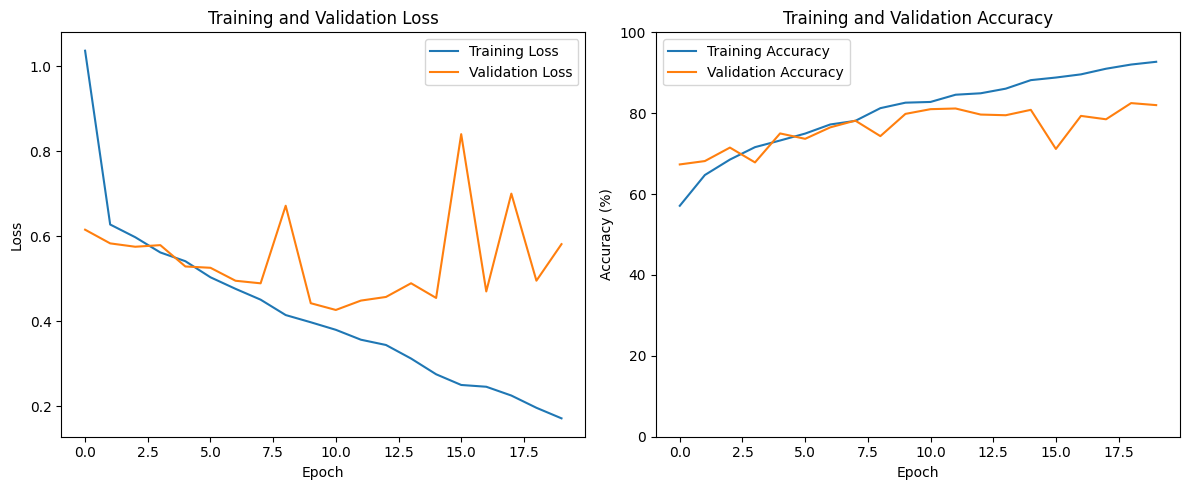

In [41]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# 2.3

### Augmentation transform

In [42]:
transform_with_aug = transforms.Compose([
    transforms.Resize((150, 150)),
    # transforms.Pad(10, padding_mode='reflect'), 
    transforms.RandomRotation(40, fill=(255, 255, 255)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, shear=0.2, fill=(255, 255, 255)),
    transforms.ToTensor(),
])



### Create dataset with augmentation transform

In [43]:

# datasets with aug
train_dataset_w_aug = CustomImageDataset(train_image, train_label, transform=transform_with_aug)
val_dataset_wo_aug = CustomImageDataset(val_image, val_label, transform=transform)
test_dataset_wo_aug = CustomImageDataset(test_image, test_label, transform=transform)


In [44]:
train_with_aug_dataloader = DataLoader(train_dataset_w_aug, batch_size=20, shuffle=True)
val_no_aug_dataloader = DataLoader(val_dataset_wo_aug, batch_size=20, shuffle=False)
test_no_aug_dataloader = DataLoader(test_dataset_wo_aug, batch_size=20, shuffle=False)

tensor(1)


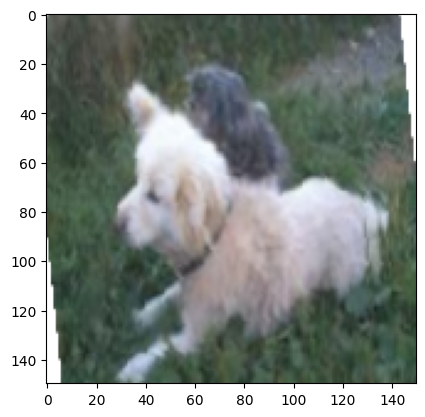

In [45]:
images, labels = next(iter(train_with_aug_dataloader))
print(labels[0])
plt.imshow(images[0].permute(1, 2, 0))

### Create CNN Model that uses new augmented training data

In [46]:
model2 = CNN().to(device)
print(model2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, e

### Training loop and Validation loop for augementation transformed training data

In [47]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_with_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model2(images)  # Forward pass
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the model on the validation set
    model2.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_no_aug_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model2(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')

torch.save(model2.state_dict(), 'model2.pth')

Epoch [1/20], Loss: 1.159811946111066, Accuracy: 54.642857142857146%
Validation Accuracy: 62.833333333333336%
Epoch [2/20], Loss: 0.6704453879169056, Accuracy: 60.285714285714285%
Validation Accuracy: 66.66666666666667%
Epoch [3/20], Loss: 0.6527616500854492, Accuracy: 63.285714285714285%
Validation Accuracy: 66.83333333333333%
Epoch [4/20], Loss: 0.6236791227545057, Accuracy: 66.35714285714286%
Validation Accuracy: 68.33333333333333%
Epoch [5/20], Loss: 0.6192418117608343, Accuracy: 66.35714285714286%
Validation Accuracy: 67.66666666666667%
Epoch [6/20], Loss: 0.6165397152304649, Accuracy: 66.03571428571429%
Validation Accuracy: 66.16666666666667%
Epoch [7/20], Loss: 0.601121176140649, Accuracy: 68.46428571428571%
Validation Accuracy: 69.66666666666667%
Epoch [8/20], Loss: 0.600838042157037, Accuracy: 69.0%
Validation Accuracy: 75.5%
Epoch [9/20], Loss: 0.5970618692891938, Accuracy: 68.96428571428571%
Validation Accuracy: 71.0%
Epoch [10/20], Loss: 0.5778022904481207, Accuracy: 69.857

### Plot results

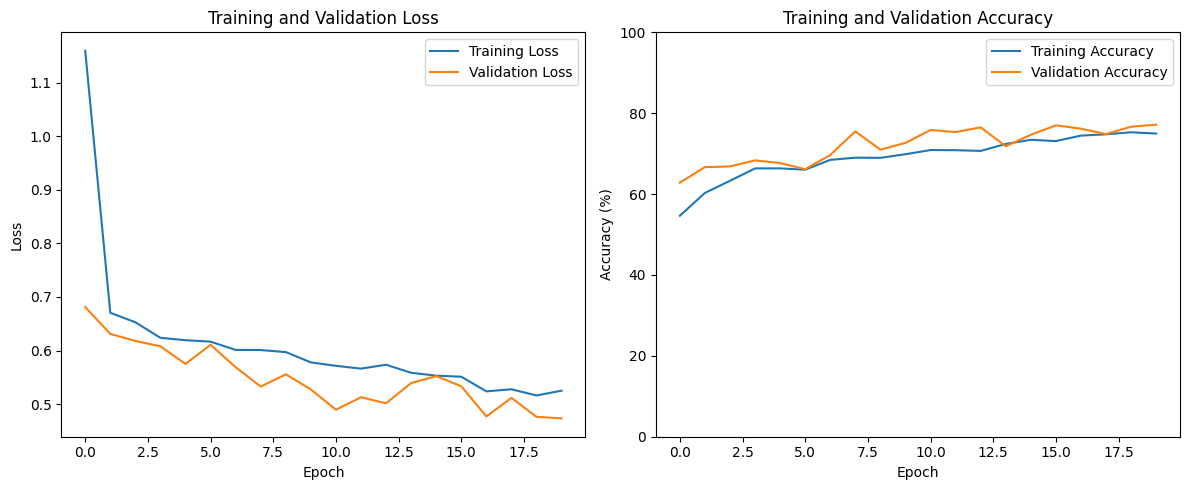

In [48]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# 2.4

# Import VGG16 pretrained weights

In [49]:
from torchvision.models import vgg16, VGG16_Weights

vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

# freeze conv base
for param in vgg16.features.parameters():
    param.requires_grad = False


### Custom VGG16 class that feeds into dense layer

In [50]:
class CustomVGG16(nn.Module):
    def __init__(self):
        super(CustomVGG16, self).__init__()

        # use the conv base of VGG16
        self.vgg16_features = vgg16.features

        # new fc layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512), # VGG16 output size is (512, 4, 4) if input shape is (150, 150, 3)
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.vgg16_features(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

### Custom VGG16 Model for training

In [51]:
customVGG16Model = CustomVGG16().to(device)
print(customVGG16Model)
criterion = nn.BCELoss()
optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, customVGG16Model.parameters()), lr = 0.001)

CustomVGG16(
  (vgg16_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [52]:
# train fully connected layers first

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    customVGG16Model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_with_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer_finetune.zero_grad()  # Zero the parameter gradients

        outputs = customVGG16Model(images)  # Forward pass
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer_finetune.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(train_with_aug_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the customVGG16Model on the validation set
    customVGG16Model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_no_aug_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = customVGG16Model(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(val_no_aug_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')


# unfreeze last block
for param in vgg16.features[24:].parameters():
    param.requires_grad = True  

num_finetune_epoch = 3

# do some finetuning on last block in VGG16 before validating it on validation dataset
for epoch in range(num_finetune_epoch):
    customVGG16Model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0 

    for images, labels in train_with_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer_finetune.zero_grad()  # Zero the parameter gradients

        outputs = customVGG16Model(images)  # Forward pass
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer_finetune.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(train_with_aug_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_finetune_epoch}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the customVGG16Model on the validation set
    customVGG16Model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_no_aug_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = customVGG16Model(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(val_no_aug_dataloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')



Epoch [1/5], Loss: 0.3757020684757403, Accuracy: 83.17857142857143%
Validation Accuracy: 94.33333333333333%
Epoch [2/5], Loss: 0.2475365000111716, Accuracy: 89.71428571428571%
Validation Accuracy: 94.16666666666667%
Epoch [3/5], Loss: 0.2353268775955907, Accuracy: 90.35714285714286%
Validation Accuracy: 94.83333333333333%
Epoch [4/5], Loss: 0.22539804821301784, Accuracy: 90.39285714285714%
Validation Accuracy: 94.66666666666667%
Epoch [5/5], Loss: 0.2053041455468961, Accuracy: 91.46428571428571%
Validation Accuracy: 94.83333333333333%
Epoch [1/3], Loss: 0.2084290251268872, Accuracy: 91.17857142857143%
Validation Accuracy: 95.66666666666667%
Epoch [2/3], Loss: 0.1877346533949354, Accuracy: 91.92857142857143%
Validation Accuracy: 95.66666666666667%
Epoch [3/3], Loss: 0.18887586783883828, Accuracy: 92.17857142857143%
Validation Accuracy: 95.0%


### Plot Custom VGG16 results

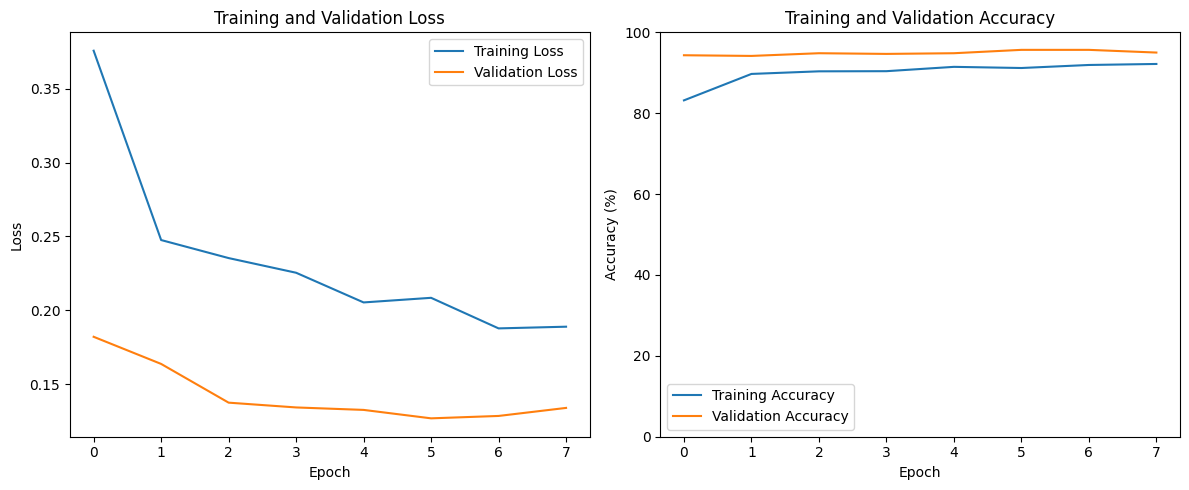

In [53]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# 2.5


In [54]:
# Evaluate the cnnModel on the test set
cnnModel.eval()
correct_val = 0
total_val = 0
val_loss = 0.0
with torch.no_grad():
    for images, labels in test_no_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = cnnModel(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute validation loss
        val_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

# Store test loss and accuracy for this epoch
val_loss /= len(val_no_aug_dataloader)
val_accuracy = 100 * correct_val / total_val

print(f'Test loss: {val_loss}')
print(f'Test Accuracy: {val_accuracy}%')

Test loss: 0.5554301500320434
Test Accuracy: 80.0%


In [55]:
# Evaluate the cnn model trained on augmented data on the test set
model2.eval()
correct_val = 0
total_val = 0
val_loss = 0.0
with torch.no_grad():
    for images, labels in test_no_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model2(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute validation loss
        val_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

# Store test loss and accuracy for this epoch
val_loss /= len(val_no_aug_dataloader)
val_accuracy = 100 * correct_val / total_val

print(f'Test loss: {val_loss}')
print(f'Test Accuracy: {val_accuracy}%')

Test loss: 0.48375194867451987
Test Accuracy: 77.83333333333333%


In [56]:
# Evaluate the customVGG16Model on the test set
customVGG16Model.eval()
correct_val = 0
total_val = 0
val_loss = 0.0
with torch.no_grad():
    for images, labels in test_no_aug_dataloader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = customVGG16Model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)  # Compute validation loss
        val_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

# Store test loss and accuracy for this epoch
val_loss /= len(val_no_aug_dataloader)
val_accuracy = 100 * correct_val / total_val

print(f'Test loss: {val_loss}')
print(f'Test Accuracy: {val_accuracy}%')

Test loss: 0.11173373486672063
Test Accuracy: 96.16666666666667%


### basic CNN model achieved 80% on test data, while CNN model that was trained on augmented training data achieved 77.8%. This could be because the augmentation parameters weren't optimized so some images are too distorted for the model. The VGG19 pretrained model achieved 96% accuracy.

### 